In [1]:
#importing required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

In [2]:
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(15, 10)})

In [3]:
%matplotlib inline

In [4]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 10

In [5]:
org_data = pd.read_excel('./data/monthly_data_total.xlsx')

In [6]:
org_data.head()

,Date,Import,Export
0,2006-01-01,12519.71,9143.66
1,2006-02-01,11479.69,8993.29
2,2006-03-01,14314.02,11560.97
3,2006-04-01,12924.18,8624.66
4,2006-05-01,15105.67,10109.30


In [7]:
org_data = org_data.set_index('Date') # set Date/Time as index

In [8]:
org_data.head()

,Import,Export
Date,,
2006-01-01,12519.71,9143.66
2006-02-01,11479.69,8993.29
2006-03-01,14314.02,11560.97
2006-04-01,12924.18,8624.66
2006-05-01,15105.67,10109.30


In [9]:
import_data = org_data[['Import']]
export_data = org_data[['Export']]

Text(0, 0.5, 'Total Traded Amount in Million US$')

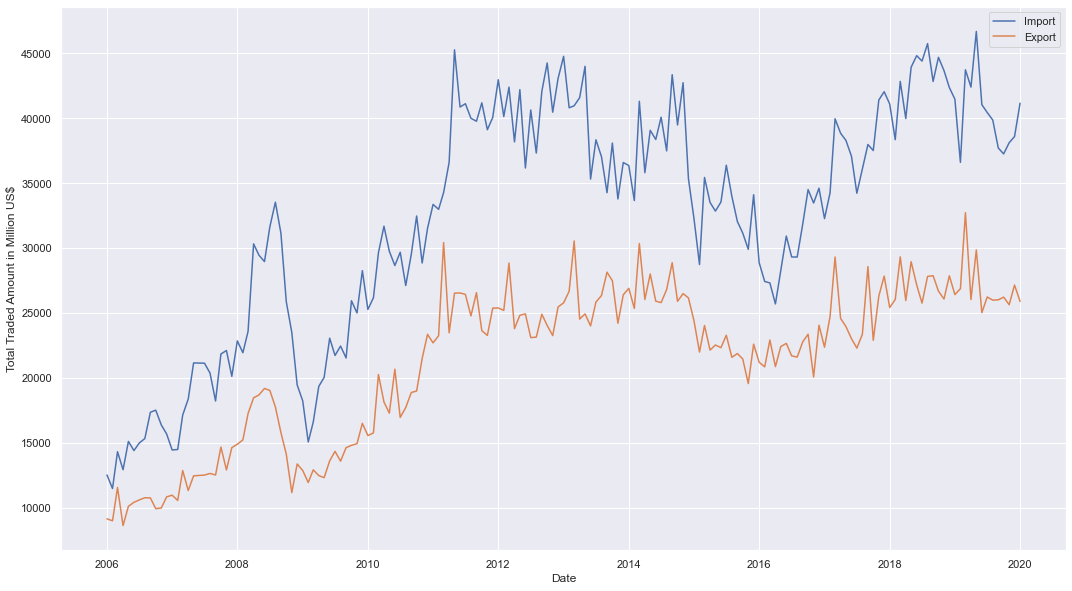

In [24]:
plt.plot(import_data, label='Import')
plt.plot(export_data, label='Export')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Total Traded Amount in Million US$')

In [11]:
# Information about data
org_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 169 entries, 2006-01-01 to 2020-01-01
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Import  169 non-null    float64
 1   Export  169 non-null    float64
dtypes: float64(2)
memory usage: 4.0 KB


In [12]:
org_data.describe()

,Import,Export
count,169.000000,169.000000
mean,32337.594970,21303.311716
std,9107.534148,5953.928014
min,11479.690000,8624.660000
25%,25935.460000,15788.700000
50%,34096.120000,23134.070000
75%,39984.320000,25981.420000
max,46672.490000,32717.300000


# Import/Export Data Forecasting

## creating train and test sets

In [83]:
mode = 'Export' # set the mode to 'Import' or 'Export' to forecast values

In [84]:
if mode=='Import':
    dataset = import_data.copy()
elif mode=='Export':
    dataset = export_data.copy()
else:
    print("Bad Mode, Enter Again!")

In [85]:
train = np.array(dataset[: 156])
valid = np.array(dataset[156: ])

In [86]:
no_of_sig_days = 12 # number of days we want to consider while forecasting next value

In [87]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler()

# Train the Scaler with training data and smooth data
smoothing_window_size = 24
for di in range(0, 156, smoothing_window_size):
    scaler.fit(train[di:di+smoothing_window_size, :])
    train[di:di+smoothing_window_size, :] = scaler.transform(train[di:di+smoothing_window_size, :])

# Normalize test data
valid = scaler.transform(valid)

In [88]:
train[13:14]

array([[0.32003676]])

In [89]:
x_train, y_train = [], []
for i in range(no_of_sig_days, len(train)):
    x_train.append(train[i-no_of_sig_days: i, :])
    y_train.append(train[i, 0])

In [90]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [64]:
train[:12]

array([[0.09789253],
       [0.        ],
       [0.26678307],
       [0.13596352],
       [0.34129762],
       [0.27485058],
       [0.32994042],
       [0.3620702 ],
       [0.55261152],
       [0.5677968 ],
       [0.46132661],
       [0.39528337]])

In [91]:
# preparing test data on which we will predicet 5 days ahead using past 252 days
inputs = np.array(dataset[156-no_of_sig_days:])
inputs = scaler.transform(inputs)

In [92]:
x_test = []
y_test = []
for i in range(no_of_sig_days, inputs.shape[0]):
    x_test.append(inputs[i-no_of_sig_days: i, :])
    y_test.append(inputs[i, 0])
x_test = np.array(x_test)
y_test = np.array(y_test)

In [67]:
# building neural networks and adding layers

model = Sequential()
model.add(LSTM(200, input_shape=(x_train.shape[1], 1), return_sequences=True)) 
# model.add(Dropout(0.2))
model.add(LSTM(200, input_shape=(x_train.shape[1],1), return_sequences=True)) 
# model.add(Dropout(0.2))
model.add(LSTM(150, input_shape=(x_train.shape[1],1), return_sequences=False)) 
model.add(Dense(1,activation='linear'))

In [68]:
model.compile(loss='mean_squared_error', optimizer='Adam')

In [69]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='min')
checkpoint = ModelCheckpoint(mode + '_model_best_weight_last_13preds.h5', monitor='val_loss', save_best_only=True, mode='min', period=1)

In [70]:
model.fit(x_train, y_train, epochs=30, batch_size=4, callbacks=[early_stop, checkpoint], verbose=1, validation_data=(x_test, y_test)) # verbose=1 shows us the progress of epochs

Train on 144 samples, validate on 13 samples
Epoch 1/30
144/144 [==============================] - 9s 62ms/sample - loss: 0.1078 - val_loss: 0.2416
Epoch 2/30
144/144 [==============================] - 5s 32ms/sample - loss: 0.0761 - val_loss: 0.3376
Epoch 3/30
144/144 [==============================] - 5s 34ms/sample - loss: 0.0826 - val_loss: 0.1599
Epoch 4/30
144/144 [==============================] - 5s 32ms/sample - loss: 0.0663 - val_loss: 0.2799
Epoch 5/30
144/144 [==============================] - 4s 30ms/sample - loss: 0.0644 - val_loss: 0.1881
Epoch 6/30
144/144 [==============================] - 4s 31ms/sample - loss: 0.0570 - val_loss: 0.1862
Epoch 7/30
144/144 [==============================] - 4s 31ms/sample - loss: 0.0533 - val_loss: 0.1897
Epoch 8/30
144/144 [==============================] - 5s 32ms/sample - loss: 0.0503 - val_loss: 0.1465
Epoch 9/30
144/144 [==============================] - 5s 32ms/sample - loss: 0.0543 - val_loss: 0.1367
Epoch 10/30
144/144 [=======

In [94]:
# load pretrained best model weights into new model
model.load_weights(mode + "_model_best_weight_last_13preds.h5")
# save best model
# model.save(mode + "_optim_model_best.h5")

In [95]:
pred = model.predict(x_test, batch_size=1)

In [96]:
pred = scaler.inverse_transform(pred)

Text(0, 0.5, 'Traded Export Amount in Million US$')

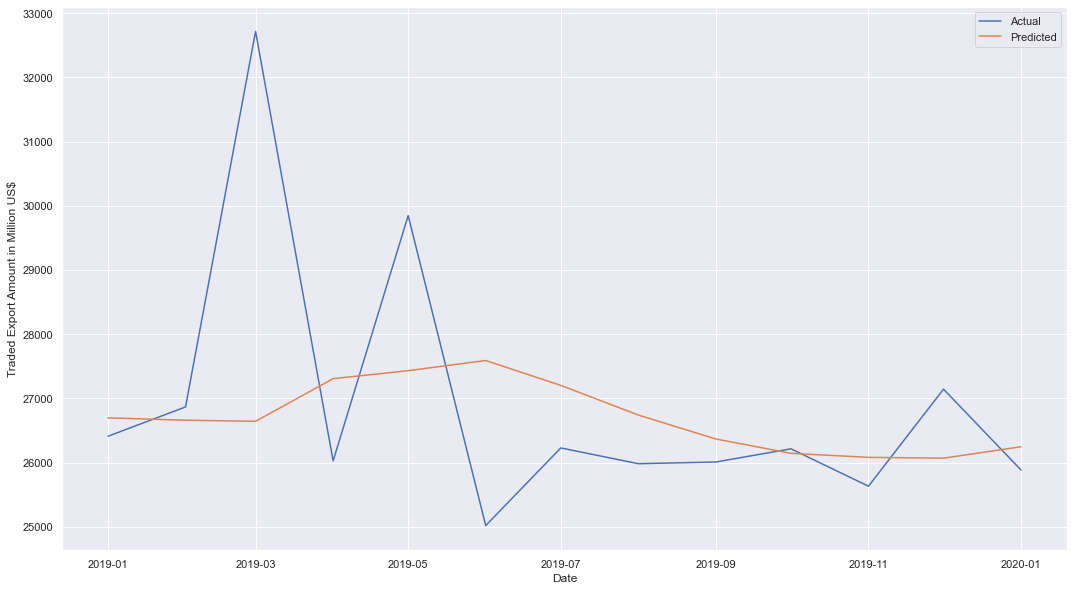

In [97]:
# for plotting
if mode=='Import':
    plt.plot(import_data[156:], label='Actual')
    plt.plot(import_data.index[156:], pred, label='Predicted')
elif mode=='Export':
    plt.plot(export_data[156:], label='Actual')
    plt.plot(export_data.index[156:], pred, label='Predicted')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Traded ' + mode + ' Amount in Million US$')

In [98]:
pred = np.array(pred).reshape(-1)

In [99]:
if mode=='Import':
    act = np.array(import_data[156:]).reshape(-1)
elif mode=='Export':
    act = np.array(export_data[156:]).reshape(-1)
Error = pd.Series(abs(pred - act))
Error.describe()

count      13.000000
mean     1299.063786
std      1641.709475
min        70.388047
25%       358.826875
50%       758.206953
75%      1280.982109
max      6075.387891
dtype: float64

In [100]:
pred

array([26695.824, 26659.018, 26641.912, 27306.662, 27430.877, 27589.527,
       27202.01 , 26739.627, 26366.797, 26143.002, 26080.37 , 26067.748,
       26245.19 ], dtype=float32)

In [101]:
act

array([26408.97, 26865.68, 32717.3 , 26025.68, 29847.36, 25017.07,
       26227.1 , 25981.42, 26007.97, 26213.39, 25630.87, 27142.63,
       25882.9 ])

In [102]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(act, pred, squared=False)
mse

2043.3924914490474